# Preprocessing #


In [ ]:
import pandas as pd
import os
os.chdir("../input")

## Train-metadata excelsheet preview

In [ ]:
meta_data = pd.read_csv("train.csv")
meta_data.head()

## Sorting training data, according to the label provided in the csv spreadsheet

In [ ]:
train_dir = "train/train"
test_dir =  "test/test"
os.listdir(train_dir)[:5]
print(len(os.listdir(train_dir)))

# Creating training, and validation generators for the purpose of feeding data into the network. 15000 to 2500.

In [47]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#######Wiithout data augumentation, just for experimental purposes...#########

train_gen = ImageDataGenerator(rescale = 1/255,
                              horizontal_flip = True,
                              height_shift_range = 0.2,
                              width_shift_range = 0.2,
                              brightness_range = [0.2,1.2],
                              rotation_range = 0.2,
                              zoom_range = 0.2,
                              shear_range = 0.2,
                              fill_mode = "nearest",
                              vertical_flip = True)
                              #fill_mode="nearest")
valid_gen = ImageDataGenerator(rescale=1/255)

meta_data.has_cactus = meta_data.has_cactus.astype(str)

train_generator = train_gen.flow_from_dataframe(
    dataframe = meta_data[:15000],
    target_size=(32,32),
    directory = train_dir,
    x_col="id",
    y_col="has_cactus",
    class_mode = "binary"
)

valid_generator = valid_gen.flow_from_dataframe(
    dataframe = meta_data[15000:],
    target_size = (32,32),
    directory = train_dir,
    x_col = "id",
    y_col = "has_cactus",
    class_mode = "binary",
)


Found 15000 validated image filenames belonging to 2 classes.
Found 2500 validated image filenames belonging to 2 classes.


# Performing transfer learning on the state of the art model VGG19

In [ ]:
from tensorflow import keras
from tensorflow.keras.applications.vgg19 import VGG19

base_model = VGG19(input_shape=(32,32,3),include_top=False, weights="imagenet")

In [ ]:
# VGG19 is a state of the art model which has been trained on imagenet dataset
# For our purposes we select the input shape as (32x32x3), here is the summary of the model.
# We can see there are 5 blocks of convolution, and pooling layers.
base_model.summary()

In [ ]:
#locking all the layers to prevent their training, as we only want to extend it by adding our own Dense layer classifier.

for layer in base_model.layers:
    layer.trainable = False
    
#Extracting last layer, and collecting it's last output, which we will use to feed into our extended model.

last_layer = base_model.get_layer("block5_pool")
last_output = last_layer.output

#Adding out own extended version of the model. For simplicity lets take it to 512 neurons in FC layer. And 2 
#neurons in the last layer for classification purpose.

extend = keras.layers.Flatten()(last_output)
extend = keras.layers.Dense(1024, activation="relu")(extend)
extend = keras.layers.Dropout(0.2)(extend)
extend = keras.layers.Dense(512, activation = "relu") (extend)
extend = keras.layers.Dropout(0.2)(extend)
extend = keras.layers.Dense(256, activation = "relu") (extend)
extend = keras.layers.Dropout(0.2)(extend)
extend = keras.layers.Dense(1, activation="sigmoid")(extend)

#Defining our extended model now

model = keras.models.Model(base_model.input, extend)

#All looks good, let's compile our model now. We'll use loss as categorical_crossentropy, and optimizer as adam

model.compile(loss = "binary_crossentropy",
             optimizer="adam",
             metrics=["acc"])

model.summary()

# Model training, without troubleshooting any overfitting, just for the sake of experimentation

In [ ]:

model.fit_generator(
    train_generator,
    validation_data = valid_generator,
    verbose = 1,
    epochs = 1000,
    shuffle=True
)

Epoch 1/1000
469/469 [==============================] - 23s 50ms/step - loss: 0.1028 - acc: 0.9599 - val_loss: 0.0701 - val_acc: 0.9752
Epoch 2/1000
469/469 [==============================] - 24s 50ms/step - loss: 0.1034 - acc: 0.9607 - val_loss: 0.0713 - val_acc: 0.9788
Epoch 3/1000
469/469 [==============================] - 23s 48ms/step - loss: 0.0997 - acc: 0.9635 - val_loss: 0.0653 - val_acc: 0.9768
Epoch 4/1000
469/469 [==============================] - 23s 49ms/step - loss: 0.1019 - acc: 0.9617 - val_loss: 0.0652 - val_acc: 0.9760
Epoch 5/1000
37/79 [=============>................] - ETA: 1s - loss: 0.0537 - acc: 0.9831

# First I trained model with different configs, here are the results
# 512 nodes, adam approx  validation accuracy 97.65
# 512 nodes, RMSprop with lr=0.001  validation accuracy 97.55
# 512 nodes, RMSpop with lr= 0.000001  validation accuracy 97.62
# 1024 nodes, adam approx validation accuracy = 97.75
# 1024 nodes, first with adam then RMSprop with lr = 0.0000000001 validation_acc = 0.9812
# 1024 nodes, first with adam then RMSprop with lr = 0.000001 validation_acc = 0.9812
# 1024 nodes, first with adam then RMSprop with lr = 0.001 validation_acc = 0.9796
# 1024=>512 nodes, adam validation accuracy = 0.9764-0.9816
# 1024=>512 nodes, SGD validation accuracy = 0.9804
# 1024=>512 nodes, SGD->Adam validation accuracy = 0.9824=>0.9800=>0.9875 and more degradation
# 1024=>512=>dropout  Adam->SGD lr =0.001 validation accuracy = 0.9800
# 1024=>512=>dropout  Adam->SGD lr = 0.0001 validatio accuracy = 0.9800
# Selected pool layer from block 3 in an attempt to get a better result, but ended up at validation accuracy = 0.70
# The training is kinda stuck between 97 to 98.25%, I think a more complex network can help in it, if not let's see how the obtained results perform on test images
# 1024=>dropout=>512=>dropout=>256=>dropout, adam, validation accuracy =  0.9736


In [49]:
history = model.history

In [50]:
acc = history.history["acc"]
loss = history.history["loss"]
val_acc = history.history["val_acc"]
val_loss = history.history["val_loss"]
epochs = range(len(acc))

<Figure size 432x288 with 0 Axes>

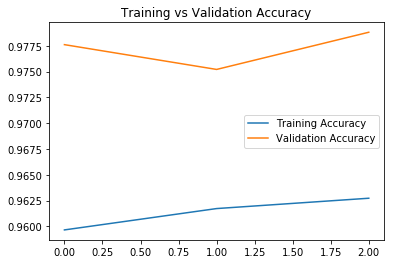

<Figure size 432x288 with 0 Axes>

In [52]:
import matplotlib.pyplot as plt


plt.plot(epochs, acc, label="Training Accuracy")
plt.plot(epochs, val_acc, label="Validation Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.figure()

In [ ]:
#model.save("my_model.h5")

# Predicting the test images

In [ ]:
os.listdir("test/test")[:5]

In [ ]:
import cv2
images = []

for image in os.listdir("test/test"):
    images.append( cv2.imread("test/test/" + image))


In [ ]:
import numpy as np
image = np.asarray(images)

In [ ]:
image.resize(4000, 32, 32, 3)
image.shape

In [ ]:
prediction = model.predict(image)
prediction.resize(4000)

In [ ]:
sub = pd.DataFrame({"id" : os.listdir(test_dir),
                   "has_cactus" : prediction})

In [ ]:
sub.head()

In [ ]:
sub.to_csv("../working/samplesubmission.csv", index=False)